## Setup
* 제약 조건
    * 이미지의 배치 순서는 정해져 있다
* V3 에서 LBP global 연산 추가
* 인사이트 : global & local 일관성이 더 중요한듯
* 일일이 scale을 맞추지 않고 log 취함

In [21]:
GLOBAL_SEED = 42

import os
os.environ['PYTHONHASHSEED'] = str(GLOBAL_SEED)

import numpy as np # linear algebra
from numpy import random as np_rnd
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import random as rnd
import pickle
import gc
import time
import string
from itertools import product, permutations

import torch
from torchvision import transforms
from PIL import Image
from torchvision.transforms import functional as tvf
from skimage.feature import hog, local_binary_pattern
import cv2

import optuna
from optuna import Trial, create_study
from optuna.samplers import TPESampler, RandomSampler, QMCSampler, BruteForceSampler, NSGAIISampler
import operator

import warnings
warnings.filterwarnings('ignore')

### Define helper functions

In [22]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    # python random
    rnd.seed(seed)
    # numpy random
    np_rnd.seed(seed)
    # RAPIDS random
    try:
        cupy.random.seed(seed)
    except:
        pass
    # tf random
    try:
        tf_rnd.set_seed(seed)
    except:
        pass
    # pytorch random
    try:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    except:
        pass

def pickleIO(obj, src, op="r"):
    if op=="w":
        with open(src, op + "b") as f:
            pickle.dump(obj, f)
    elif op=="r":
        with open(src, op + "b") as f:
            tmp = pickle.load(f)
        return tmp
    else:
        print("unknown operation")
        return obj
    
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)

def findIdx(data_x, col_names):
    return [int(i) for i, j in enumerate(data_x) if j in col_names]

def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

In [23]:
class CFG:
    debug = False
    image_root_path = "./data/"
    # h, w
    target_grid = (2, 2)
    operations = {
        "mirroring": lambda x: tvf.hflip(x),
        "flipping": lambda x: tvf.vflip(x),
        "rotation": lambda x: tvf.rotate(x, 90, expand=True)[:, :x.shape[2], :x.shape[1]],
    }
    inverse_operations = {
        "mirroring": lambda x: tvf.hflip(x),
        "flipping": lambda x: tvf.vflip(x),
        "rotation": lambda x: tvf.rotate(x, -90, expand=True)[:, :x.shape[2], :x.shape[1]],
    }
    shuffled_image_name_length = 4
    max_loss_value = 1000.0

## Loading data

In [24]:
image_name = "yerin2.jpg"
shuffled_image_root_path = CFG.image_root_path + "random_" + image_name.split(".")[0] + "/"
createFolder(shuffled_image_root_path)

In [25]:
# 이미지 파일 경로
image_path = CFG.image_root_path + image_name
# 이미지 불러오기
image = Image.open(image_path)
# 이미지를 PyTorch Tensor로 변환
image = transforms.ToTensor()(image)
c, h, w = image.shape
c, h, w

(3, 505, 551)

## Split & Apply random operations

In [26]:
operation_order = list(permutations(CFG.operations.keys()))
seed_everything()
selected_order = operation_order[rnd.randint(0, len(operation_order) - 1)]

In [27]:
# def do_random_operation(image, debug=False):
#     if debug:
#         seed_everything()
#     x = image.clone()
#     if rnd.random() > 0.5:
#         for op in selected_order:
#             x = CFG.operations[op](x)
#     return x

# # 이미지별 모든 연산 일괄적으로 적용
# def do_random_operation(image, debug=False):
#     if debug:
#         seed_everything()
#     x = image.clone()
#     if rnd.random() > 0.5:
#         for op in selected_order:
#             x = CFG.operations[op](x)
#     return x

# 이미지별 모든 연산 독립적으로 적용
def do_random_operation(image, debug=False):
    if debug:
        seed_everything()
    x = image.clone()
    for op in operation_order[rnd.randint(0, len(operation_order) - 1)]:
        if rnd.random() > 0.5:
            x = CFG.operations[op](x)
    return x


# 무작위로 이름을 생성하는 함수
def generate_random_name(length, seed=42):
    rnd.seed(seed)
    # 대소문자 알파벳과 숫자로 이루어진 문자열을 생성
    characters = string.ascii_letters + string.digits
    # 무작위로 길이가 `length`인 문자열 생성
    random_name = ''.join(rnd.choice(characters) for _ in range(length))
    return random_name

In [28]:
grid_h, grid_w = h // CFG.target_grid[0], w // CFG.target_grid[1]
grid_h, grid_w

(252, 275)

In [29]:
for fpath in os.listdir(shuffled_image_root_path):
    os.remove(shuffled_image_root_path + fpath)

seed_cnt = 0
for idx_h in range(CFG.target_grid[0]):
    for idx_w in range(CFG.target_grid[1]):
        seed_everything(seed_cnt)
        cropped_image = image[:, (idx_h * grid_h):((idx_h+1) * grid_h), (idx_w * grid_w):((idx_w+1) * grid_w)]
        cropped_image = do_random_operation(cropped_image, debug=CFG.debug)
        cropped_image = transforms.ToPILImage()(cropped_image)
        cropped_image.save(shuffled_image_root_path + f"{str(seed_cnt).zfill(CFG.shuffled_image_name_length)}.jpg")
        seed_cnt += 1
        # break

## Re-construction

### Loading sub-images

In [30]:
image_container = [transforms.ToTensor()(Image.open(shuffled_image_root_path + i)) for i in sorted(os.listdir(shuffled_image_root_path))]
len(image_container)

4

In [31]:
resolution_metainfo = []
for idx, value in enumerate(image_container):
    resolution_metainfo.append({
        "idx": idx,
        "h": value.shape[1],
        "w": value.shape[2],
    })
resolution_metainfo = pd.DataFrame(resolution_metainfo)
print(resolution_metainfo)
resolution_range = tuple(set(resolution_metainfo["h"].to_list() + resolution_metainfo["w"].to_list()))
# resolution range must be less than 3
assert len(resolution_range) <= 2
print(resolution_range)

   idx    h    w
0    0  252  275
1    1  275  252
2    2  252  275
3    3  252  275
(275, 252)


In [32]:
hog_params = {
    "orientations": 9,
    "cells_per_block": (3, 3),
    "pixels_per_cell": (3, 3),
    "channel_axis": 0,
}
lbp_params = {
    "P": 3 * 3,
    "R": 3,
    "method": "uniform",
}

def get_pixel_histogram_feature_vector(x, n_bins=64):
    output = []
    for i in x:
        histogram, _ = torch.histogram(i, bins=n_bins, range=(0, 1))
        # normalizing by channels
        output.append(histogram / histogram.sum())
    return torch.cat(output, dim=-1)

def get_hog_feature_vector(x):
    return torch.from_numpy(hog(x.detach().cpu().numpy(), **hog_params).flatten())

def get_lbp_feature_vector(x):
    return torch.from_numpy(local_binary_pattern(tvf.rgb_to_grayscale(x).squeeze(dim=0).detach().cpu().numpy(), **lbp_params).flatten())

def get_pixel_variety(x1, x2, n_bins=64):
    pixel_variety = torch.stack([torch.histogram(i, bins=n_bins, range=(0, 1))[0] for i in x1]) + torch.stack([torch.histogram(i, bins=n_bins, range=(0, 1))[0] for i in x2])
    return 1 / (pixel_variety.flatten().std().item() + 1.0)

def get_local_blended_score(x1, x2):
    score = [
        torch.sqrt(torch.pow(x1.flatten() - x2.flatten(), 2).mean()).item() / 3.0 * 1.5,
        torch.sqrt(torch.pow(get_pixel_histogram_feature_vector(x1) - get_pixel_histogram_feature_vector(x2), 2).mean()).item() * 20.0,
        torch.sqrt(torch.pow(get_hog_feature_vector(x1) - get_hog_feature_vector(x2), 2).mean()).item(),
        torch.sqrt(torch.pow(get_lbp_feature_vector(x1) - get_lbp_feature_vector(x2), 2).mean()).item() / 100.0,
        get_pixel_variety(x1, x2),
    ]
    # score = [
    #     torch.sqrt(torch.pow(x1.flatten() - x2.flatten(), 2).mean()).item(),
    #     torch.sqrt(torch.pow(get_pixel_histogram_feature_vector(x1) - get_pixel_histogram_feature_vector(x2), 2).mean()).item(),
    #     torch.sqrt(torch.pow(get_hog_feature_vector(x1) - get_hog_feature_vector(x2), 2).mean()).item(),
    #     torch.sqrt(torch.pow(get_lbp_feature_vector(x1) - get_lbp_feature_vector(x2), 2).mean()).item(),
    # ]
    # print(score)
    return np.mean(score)
    # return np.mean(np.log1p(score))

def get_consistency_score(x, order):
    if isinstance(x, list):
        x = torch.stack(x, dim=0)

    rows_global = []
    rows_local_binary = []
    rows_local_lbp = []
    row_idx = np.array([int(np.floor(order[i] / (CFG.target_grid[1]))) for i in range(len(x))])
    for i in range(CFG.target_grid[0]):
        row_image = x[row_idx == i]
        row_order = order[row_idx == i]

        rows_global.append(torch.cat([j for j in row_image[np.argsort(row_order)]], dim=-1))
        rows_local_binary.append(torch.cat([torch.from_numpy(cv2.threshold(np.array(transforms.ToPILImage()(tvf.rgb_to_grayscale(j).squeeze(dim=0))), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]) for j in row_image[np.argsort(row_order)]], dim=-1))
        rows_local_lbp.append(torch.cat([torch.from_numpy(local_binary_pattern(tvf.rgb_to_grayscale(j).squeeze(dim=0).detach().cpu().numpy(), **lbp_params).flatten()) for j in row_image[np.argsort(row_order)]], dim=-1))

    rows_global = torch.cat(rows_global, dim=1)
    rows_global_binary = torch.from_numpy(cv2.threshold(np.array(transforms.ToPILImage()(tvf.rgb_to_grayscale(rows_global).squeeze(dim=0))), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]).to(torch.float32)
    rows_global_lbp = torch.from_numpy(local_binary_pattern(tvf.rgb_to_grayscale(rows_global).squeeze(dim=0).detach().cpu().numpy(), **lbp_params).flatten()).to(torch.float32)
    rows_local_binary = torch.cat(rows_local_binary, dim=0).to(torch.float32)
    rows_local_lbp = torch.cat(rows_local_lbp, dim=0).to(torch.float32)

    output = [
        {"thresholding_consistency": torch.sqrt(torch.pow(rows_global_binary - rows_local_binary, 2).mean()).item() / 200.0},
        {"lbp_consistency": torch.sqrt(torch.pow(rows_global_lbp - rows_local_lbp, 2).mean()).item() / 25.0},
    ]
    # score = [
    #     torch.sqrt(torch.pow(rows_global_binary - rows_local_binary, 2).mean()).item(),
    #     torch.sqrt(torch.pow(rows_global_lbp - rows_local_lbp, 2).mean()).item(),
    # ]
    return output
    # return np.mean(np.log1p(score))

In [33]:
# V3
def get_edge_similarity_score(transformed_image, position_order, ratio=0.05, min_edge_pixels=9, consistency_score_weight="local_size"):
    score = []
    for pos in position_order:

        # check height upper
        if (pos + (CFG.target_grid[1] * -1)) >= 0:
            target_image = transformed_image[position_order.index(pos + (CFG.target_grid[1] * -1))]
            pos_image = transformed_image[position_order.index(pos)]
            # if shape is not matched, return large loss value
            if target_image.shape[2] != pos_image.shape[2]:
                score.append({tuple(sorted([pos, (pos + (CFG.target_grid[1] * -1))])): CFG.max_loss_value})
            else:
                # for target image
                target_image = target_image[:, (-1 * max(min_edge_pixels, int(target_image.shape[1] * ratio))):, :]
                
                # for present image
                pos_image = pos_image[:, :(1 * max(min_edge_pixels, int(pos_image.shape[1] * ratio))):, :]

                target_image = tvf.vflip(target_image)
                # get l2 distance from feature vector
                target_image = tvf.vflip(target_image)
                score.append({tuple(sorted([pos, (pos + (CFG.target_grid[1] * -1))])): get_local_blended_score(target_image, pos_image)})
                

        # check height lower
        if (pos + (CFG.target_grid[1] * 1)) <= (CFG.target_grid[0] * CFG.target_grid[1] - 1):
            target_image = transformed_image[position_order.index(pos + (CFG.target_grid[1] * 1))]
            pos_image = transformed_image[position_order.index(pos)]
            # if shape is not matched, return large loss value
            if target_image.shape[2] != pos_image.shape[2]:
                score.append({tuple(sorted([pos, (pos + (CFG.target_grid[1] * 1))])): CFG.max_loss_value})
            else:                
                # for target image
                target_image = target_image[:, :(1 * max(min_edge_pixels, int(target_image.shape[1] * ratio))), :]
                target_image = tvf.vflip(target_image)
                # for present image
                pos_image = pos_image[:, (-1 * max(min_edge_pixels, int(pos_image.shape[1] * ratio))):, :]
                # get l2 distance from feature vector
                score.append({tuple(sorted([pos, (pos + (CFG.target_grid[1] * 1))])): get_local_blended_score(target_image, pos_image)})
            
        # check width left
        if int(np.floor((pos - 1) / CFG.target_grid[1])) == int(np.floor(pos / CFG.target_grid[1])):
            # print(44)
            target_image = transformed_image[position_order.index(pos - 1)]
            pos_image = transformed_image[position_order.index(pos)]
            # if shape is not matched, return large loss value
            if target_image.shape[1] != pos_image.shape[1]:
                # print(33)
                score.append({tuple(sorted([pos, (pos - 1)])): CFG.max_loss_value})
                # print(score)
            else:                
                # for target image
                target_image = target_image[:, :, (-1 * max(min_edge_pixels, int(target_image.shape[2] * ratio))):]
                target_image = tvf.hflip(target_image)
                # for present image
                pos_image = pos_image[:, :, :(1 * max(min_edge_pixels, int(pos_image.shape[2] * ratio)))]
                # get l2 distance from feature vector
                score.append({tuple(sorted([pos, (pos - 1)])): get_local_blended_score(target_image, pos_image)})

        # check width right
        if int(np.floor((pos + 1) / CFG.target_grid[1])) == int(np.floor(pos / CFG.target_grid[1])):
            target_image = transformed_image[position_order.index(pos + 1)]
            pos_image = transformed_image[position_order.index(pos)]
            # if shape is not matched, return large loss value
            if target_image.shape[1] != pos_image.shape[1]:
                score.append({tuple(sorted([pos, (pos + 1)])): CFG.max_loss_value})
            else:                
                # for target image
                target_image = target_image[:, :, :(1 * max(min_edge_pixels, int(target_image.shape[2] * ratio)))]
                target_image = tvf.hflip(target_image)
                # for present image
                pos_image = pos_image[:, :, (-1 * max(min_edge_pixels, int(pos_image.shape[2] * ratio))):]
                # get l2 distance from feature vector
                score.append({tuple(sorted([pos, (pos + 1)])): get_local_blended_score(target_image, pos_image)})

    # df_score = pd.Series([list(i.values())[0] for i in score], index=[list(i.keys())[0] for i in score])
    # df_score.index.name = "pair"
    # df_score = df_score.groupby("pair").mean()

    # local_score = df_score.mean()
    # global_score = get_consistency_score(transformed_image, position_order) * (consistency_score_weight if isinstance(consistency_score_weight, float) else (1 / len(transformed_image)))
    # # print(local_score, global_score)
    # return local_score + global_score

    score.extend(get_consistency_score(transformed_image, np.array(position_order)))
    
    df_score = pd.Series([list(i.values())[0] for i in score], index=[list(i.keys())[0] for i in score])
    # print(df_score)
    df_score.index.name = "pair"
    df_score = df_score.groupby("pair").mean()

    return df_score.mean()

In [34]:
inverse_operation_order = list(permutations(CFG.inverse_operations.keys()))

# optuna function
def optuna_objective_function(trial: Trial, output_container):

    transformed_image = [i.clone() for i in image_container]
    
    # set searching parameters
    tuner_params = {}
    for i in range(len(transformed_image)):
        tuner_params[f"img{i}_opSeq"] = trial.suggest_categorical(f"img{i}_opSeq", list(range(len(inverse_operation_order))))
        for op in CFG.inverse_operations.keys():
            if op != "rotation":
                tuner_params[f"img{i}_{op}"] = trial.suggest_categorical(f"img{i}_{op}", [0, 1])
        # tuner_params[f"img{i}_rank"] = trial.suggest_float(f"img{i}_rank", 0.0, 1.0)
    # set resolution indicating paramter for reducing complexity
    tuner_params["resolution_h"] = trial.suggest_categorical(f"resolution_h", resolution_range)

    # transform images with seaching params & assign order
    # first, align all images with selected resolution
    for i in range(len(transformed_image)):
        for op in inverse_operation_order[tuner_params[f"img{i}_opSeq"]]:
            if op != "rotation":
                if tuner_params[f"img{i}_{op}"] == 1:
                    transformed_image[i] = CFG.inverse_operations[op](transformed_image[i])
            else:
                if transformed_image[i].shape[1] != tuner_params["resolution_h"]:
                    transformed_image[i] = CFG.inverse_operations["rotation"](transformed_image[i])

    # assign postion on images
    # position_order = list(np.argsort([tuner_params[f"img{i}_rank"] for i in range(len(transformed_image))]))
    position_order = list(range(len(transformed_image)))

    # calcuate edge similarity score
    optuna_score = get_edge_similarity_score(transformed_image, position_order)
    
    if optuna_score < output_container["optuna_score"]:
        output_container["optuna_score"] = optuna_score
        print(f"Found best at {trial.number} trial (Score -> {optuna_score})")

    return optuna_score

class Optuna_EarlyStoppingCallback(object):
    """Early stopping callback for Optuna."""

    def __init__(self, early_stopping_rounds: int, direction: str = "minimize") -> None:
        self.early_stopping_rounds = early_stopping_rounds

        self._iter = 0

        if direction == "minimize":
            self._operator = operator.lt
            self._score = np.inf
        elif direction == "maximize":
            self._operator = operator.gt
            self._score = -np.inf
        else:
            ValueError(f"invalid direction: {direction}")

    def __call__(self, study: optuna.Study, trial: optuna.Trial) -> None:
        """Do early stopping."""
        if self._operator(study.best_value, self._score):
            self._iter = 0
            self._score = study.best_value
        else:
            self._iter += 1

        if self._iter >= self.early_stopping_rounds:
            study.stop()

### Optimization

In [35]:
def do_optimization(seed):
    generic_sampler_params = {
        "population_size": 50,
        "mutation_prob": 0.05,
        "crossover_prob": 0.8,
        "swapping_prob": 0.5,
        "seed": seed,
    }

    output_container = {"optuna_score": np.inf}
    optuna_direction = "minimize"
    optuna_trials = 10_000
    optuna_earlyStopping = Optuna_EarlyStoppingCallback(max(1, int(optuna_trials * 0.2)), direction=optuna_direction)

    optuna_timout = 6 * 3600
    optuna_study = create_study(direction=optuna_direction, sampler=NSGAIISampler(**generic_sampler_params))

    optuna_study.optimize(
        lambda trial: optuna_objective_function(
            trial, output_container,
        ),
        n_jobs=-1, n_trials=optuna_trials, timeout=optuna_timout, callbacks=[optuna_earlyStopping]
    )
    
    return optuna_study.best_params

In [36]:
%%time

try_seed = 1

seed_everything(try_seed)

best_params = do_optimization(try_seed)

[I 2023-09-10 10:38:02,239] A new study created in memory with name: no-name-aff10d5e-088f-4ba2-a851-496c1cbc845c
[I 2023-09-10 10:38:03,911] Trial 0 finished with value: 0.17925783046353802 and parameters: {'img0_opSeq': 2, 'img0_mirroring': 0, 'img0_flipping': 1, 'img1_opSeq': 5, 'img1_mirroring': 0, 'img1_flipping': 1, 'img2_opSeq': 2, 'img2_mirroring': 1, 'img2_flipping': 1, 'img3_opSeq': 0, 'img3_mirroring': 0, 'img3_flipping': 1, 'resolution_h': 275}. Best is trial 0 with value: 0.17925783046353802.
[I 2023-09-10 10:38:04,071] Trial 4 finished with value: 0.1670165605659588 and parameters: {'img0_opSeq': 2, 'img0_mirroring': 1, 'img0_flipping': 1, 'img1_opSeq': 4, 'img1_mirroring': 0, 'img1_flipping': 0, 'img2_opSeq': 0, 'img2_mirroring': 1, 'img2_flipping': 1, 'img3_opSeq': 0, 'img3_mirroring': 1, 'img3_flipping': 0, 'resolution_h': 252}. Best is trial 4 with value: 0.1670165605659588.
[I 2023-09-10 10:38:04,087] Trial 3 finished with value: 0.18321581864973116 and parameters: {

Found best at 0 trial (Score -> 0.17925783046353802)
Found best at 4 trial (Score -> 0.1670165605659588)


[I 2023-09-10 10:38:04,113] Trial 8 finished with value: 0.19231106366063622 and parameters: {'img0_opSeq': 5, 'img0_mirroring': 1, 'img0_flipping': 0, 'img1_opSeq': 1, 'img1_mirroring': 0, 'img1_flipping': 1, 'img2_opSeq': 4, 'img2_mirroring': 1, 'img2_flipping': 1, 'img3_opSeq': 3, 'img3_mirroring': 0, 'img3_flipping': 1, 'resolution_h': 252}. Best is trial 4 with value: 0.1670165605659588.
[I 2023-09-10 10:38:04,130] Trial 6 finished with value: 0.1918203517923124 and parameters: {'img0_opSeq': 5, 'img0_mirroring': 0, 'img0_flipping': 0, 'img1_opSeq': 3, 'img1_mirroring': 1, 'img1_flipping': 1, 'img2_opSeq': 5, 'img2_mirroring': 1, 'img2_flipping': 0, 'img3_opSeq': 4, 'img3_mirroring': 0, 'img3_flipping': 1, 'resolution_h': 252}. Best is trial 4 with value: 0.1670165605659588.
[I 2023-09-10 10:38:04,148] Trial 9 finished with value: 0.17314169116525543 and parameters: {'img0_opSeq': 5, 'img0_mirroring': 0, 'img0_flipping': 1, 'img1_opSeq': 5, 'img1_mirroring': 0, 'img1_flipping': 0,

Found best at 11 trial (Score -> 0.16177466224466067)


[I 2023-09-10 10:38:04,490] Trial 16 finished with value: 0.1793560271648281 and parameters: {'img0_opSeq': 3, 'img0_mirroring': 0, 'img0_flipping': 0, 'img1_opSeq': 0, 'img1_mirroring': 1, 'img1_flipping': 0, 'img2_opSeq': 1, 'img2_mirroring': 1, 'img2_flipping': 1, 'img3_opSeq': 2, 'img3_mirroring': 1, 'img3_flipping': 0, 'resolution_h': 275}. Best is trial 11 with value: 0.16177466224466067.
[I 2023-09-10 10:38:05,915] Trial 17 finished with value: 0.1912611080328586 and parameters: {'img0_opSeq': 1, 'img0_mirroring': 0, 'img0_flipping': 0, 'img1_opSeq': 4, 'img1_mirroring': 1, 'img1_flipping': 1, 'img2_opSeq': 5, 'img2_mirroring': 0, 'img2_flipping': 0, 'img3_opSeq': 0, 'img3_mirroring': 0, 'img3_flipping': 1, 'resolution_h': 252}. Best is trial 11 with value: 0.16177466224466067.
[I 2023-09-10 10:38:05,934] Trial 18 finished with value: 0.18426811493394546 and parameters: {'img0_opSeq': 0, 'img0_mirroring': 0, 'img0_flipping': 1, 'img1_opSeq': 0, 'img1_mirroring': 0, 'img1_flippin

Found best at 24 trial (Score -> 0.15843998026747166)


[I 2023-09-10 10:38:06,333] Trial 25 finished with value: 0.19036148601497213 and parameters: {'img0_opSeq': 3, 'img0_mirroring': 0, 'img0_flipping': 0, 'img1_opSeq': 2, 'img1_mirroring': 0, 'img1_flipping': 1, 'img2_opSeq': 5, 'img2_mirroring': 0, 'img2_flipping': 0, 'img3_opSeq': 3, 'img3_mirroring': 1, 'img3_flipping': 1, 'resolution_h': 275}. Best is trial 24 with value: 0.15843998026747166.
[I 2023-09-10 10:38:06,351] Trial 31 finished with value: 0.17484765682155567 and parameters: {'img0_opSeq': 1, 'img0_mirroring': 1, 'img0_flipping': 1, 'img1_opSeq': 0, 'img1_mirroring': 0, 'img1_flipping': 0, 'img2_opSeq': 5, 'img2_mirroring': 1, 'img2_flipping': 1, 'img3_opSeq': 3, 'img3_mirroring': 0, 'img3_flipping': 0, 'resolution_h': 252}. Best is trial 24 with value: 0.15843998026747166.
[I 2023-09-10 10:38:06,352] Trial 26 finished with value: 0.17041555408330775 and parameters: {'img0_opSeq': 1, 'img0_mirroring': 1, 'img0_flipping': 0, 'img1_opSeq': 0, 'img1_mirroring': 1, 'img1_flipp

Found best at 44 trial (Score -> 0.1576458838759958)
Found best at 45 trial (Score -> 0.1534457016641427)


[I 2023-09-10 10:38:08,347] Trial 42 finished with value: 0.179173156387939 and parameters: {'img0_opSeq': 3, 'img0_mirroring': 0, 'img0_flipping': 0, 'img1_opSeq': 5, 'img1_mirroring': 0, 'img1_flipping': 1, 'img2_opSeq': 2, 'img2_mirroring': 0, 'img2_flipping': 0, 'img3_opSeq': 4, 'img3_mirroring': 0, 'img3_flipping': 1, 'resolution_h': 275}. Best is trial 45 with value: 0.1534457016641427.
[I 2023-09-10 10:38:08,360] Trial 49 finished with value: 0.18462565171504527 and parameters: {'img0_opSeq': 3, 'img0_mirroring': 0, 'img0_flipping': 1, 'img1_opSeq': 4, 'img1_mirroring': 1, 'img1_flipping': 0, 'img2_opSeq': 4, 'img2_mirroring': 1, 'img2_flipping': 1, 'img3_opSeq': 5, 'img3_mirroring': 1, 'img3_flipping': 1, 'resolution_h': 275}. Best is trial 45 with value: 0.1534457016641427.
[I 2023-09-10 10:38:08,370] Trial 39 finished with value: 0.19014275596524344 and parameters: {'img0_opSeq': 4, 'img0_mirroring': 1, 'img0_flipping': 1, 'img1_opSeq': 0, 'img1_mirroring': 0, 'img1_flipping'

Found best at 88 trial (Score -> 0.14691999765304234)


[I 2023-09-10 10:38:14,289] Trial 89 finished with value: 0.2001729399084348 and parameters: {'img0_opSeq': 5, 'img0_mirroring': 1, 'img0_flipping': 1, 'img1_opSeq': 4, 'img1_mirroring': 0, 'img1_flipping': 0, 'img2_opSeq': 0, 'img2_mirroring': 1, 'img2_flipping': 1, 'img3_opSeq': 1, 'img3_mirroring': 1, 'img3_flipping': 0, 'resolution_h': 275}. Best is trial 88 with value: 0.14691999765304234.
[I 2023-09-10 10:38:14,418] Trial 92 finished with value: 0.19844793413541006 and parameters: {'img0_opSeq': 5, 'img0_mirroring': 1, 'img0_flipping': 0, 'img1_opSeq': 1, 'img1_mirroring': 1, 'img1_flipping': 1, 'img2_opSeq': 3, 'img2_mirroring': 0, 'img2_flipping': 1, 'img3_opSeq': 1, 'img3_mirroring': 1, 'img3_flipping': 1, 'resolution_h': 275}. Best is trial 88 with value: 0.14691999765304234.
[I 2023-09-10 10:38:14,492] Trial 97 finished with value: 0.19741206332859876 and parameters: {'img0_opSeq': 0, 'img0_mirroring': 1, 'img0_flipping': 0, 'img1_opSeq': 4, 'img1_mirroring': 1, 'img1_flippi

Found best at 150 trial (Score -> 0.14201804360530731)


[I 2023-09-10 10:38:21,223] Trial 149 finished with value: 0.17221763159937398 and parameters: {'img0_opSeq': 0, 'img0_mirroring': 1, 'img0_flipping': 0, 'img1_opSeq': 4, 'img1_mirroring': 1, 'img1_flipping': 0, 'img2_opSeq': 2, 'img2_mirroring': 0, 'img2_flipping': 0, 'img3_opSeq': 4, 'img3_mirroring': 1, 'img3_flipping': 0, 'resolution_h': 275}. Best is trial 150 with value: 0.14201804360530731.
[I 2023-09-10 10:38:22,057] Trial 153 finished with value: 0.16078818615932589 and parameters: {'img0_opSeq': 1, 'img0_mirroring': 0, 'img0_flipping': 1, 'img1_opSeq': 2, 'img1_mirroring': 1, 'img1_flipping': 1, 'img2_opSeq': 0, 'img2_mirroring': 0, 'img2_flipping': 0, 'img3_opSeq': 0, 'img3_mirroring': 1, 'img3_flipping': 1, 'resolution_h': 252}. Best is trial 150 with value: 0.14201804360530731.
[I 2023-09-10 10:38:22,095] Trial 152 finished with value: 0.1877782206046906 and parameters: {'img0_opSeq': 1, 'img0_mirroring': 1, 'img0_flipping': 0, 'img1_opSeq': 3, 'img1_mirroring': 1, 'img1_f

CPU times: total: 48min 30s
Wall time: 4min 23s


### Inference

In [37]:
transformed_image = [i.clone() for i in image_container]

# transform images with seaching params & assign order
# first, align all images with selected resolution
for i in range(len(transformed_image)):
    for op in inverse_operation_order[best_params[f"img{i}_opSeq"]]:
        if op != "rotation":
            if best_params[f"img{i}_{op}"] == 1:
                transformed_image[i] = CFG.inverse_operations[op](transformed_image[i])
        else:
            if transformed_image[i].shape[1] != best_params["resolution_h"]:
                transformed_image[i] = CFG.inverse_operations["rotation"](transformed_image[i])

# position_order = np.argsort([best_params[f"img{i}_rank"] for i in range(len(transformed_image))])
position_order = np.array(range(len(transformed_image)))
transformed_image = torch.stack(transformed_image, dim=0)
transformed_image.shape

torch.Size([4, 3, 252, 275])

In [38]:
rows = []
row_idx = np.array([int(np.floor(position_order[i] / (CFG.target_grid[1]))) for i in range(len(transformed_image))])
for i in range(CFG.target_grid[0]):
    row_image = transformed_image[row_idx == i]
    row_order = position_order[row_idx == i]
    rows.append(torch.cat([j for j in row_image[np.argsort(row_order)]], dim=-1))
    # break
final_image = torch.cat(rows, dim=1)

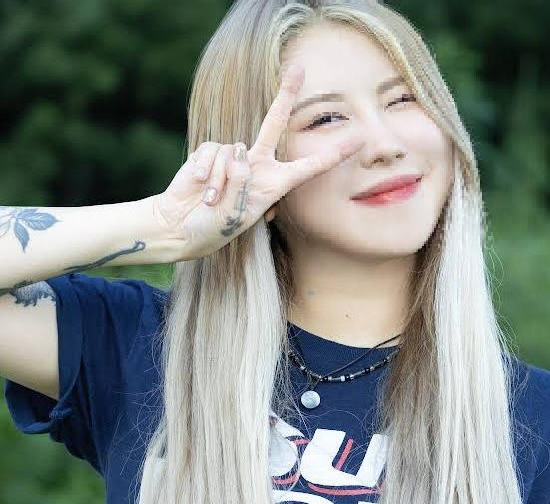

In [39]:
transforms.ToPILImage()(final_image)